In [1]:
from util import *

# Trading Notebook

Running backtests with various parameters in training, then running OOS tests.

In [ ]:
# Change to directory of dataset file
# Dataset file is guaranteed to have all days for all stocks, i.e. shift(30) is guaranteed to be 30 calendar days
# This leaves a lot of NaNs to be filled

# From s3
# path = "~/s3local/sentimentgroup/datasets/roberta_sources.parquet"
# Local copy from git
path = "./roberta_sources.parquet"

In [3]:
# Horizons to calculate future returns (e.g. price after N days)
target_horizons = [1, 3, 5, 10, 30]
# Horizons to calculate lookbacks for rolling means (e.g. mean sentiment over last N days)
lookback_periods = [5, 10, 30]

# Date range, leave None to use all available data (where we have prices)
start_date = "2014-01-01"
end_date = "2025-01-01" # Keep out of sample for now
df = load_dataset(
    path,
    target_horizons = target_horizons,
    lookback_periods = lookback_periods,
    residualise_returns = False,
    start_date=start_date,
    end_date=end_date,
    sources=True,
)

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{lookback}"] = np.array(((
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{lookback}"] = np.array(((
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [4]:
# Normalised features only
news_fts = [c for c in df.columns if c.startswith('ft_news') and c.split("_")[-1].isdigit()]
submissions_fts = [c for c in df.columns if c.startswith('ft_submissions') and c.split("_")[-1].isdigit()]
comments_fts = [c for c in df.columns if c.startswith('ft_comments') and c.split("_")[-1].isdigit()]

In [5]:
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import copy
import bisect

In [6]:
def walk_forward_predict(df, m, fts, tgt, start_date, end_date, tgt_lookhead_offset=10):
    # Create a copy and ensure datetime types
    # df = df.copy()
    # df['dt'] = pd.to_datetime(df['dt'])
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Sort by date
    df.sort_values('dt', inplace=True) #.reset_index(drop=True)
    
    # Add prediction column
    df['prediction'] = np.nan
    
    # Create a list of unique dates and their first indices
    dates_and_indices = []
    prev_date = None
    for i, date in enumerate(df['dt']):
        if date != prev_date:
            dates_and_indices.append((date, i))
            prev_date = date
    
    # Extract dates and indices into separate lists for binary search
    unique_dates = [d[0] for d in dates_and_indices]
    date_indices = [d[1] for d in dates_and_indices]
    
    # Add an end marker index
    date_indices.append(len(df))
    
    # Find the range of dates to predict
    start_pos = bisect.bisect_left(unique_dates, start_date)
    end_pos = bisect.bisect_right(unique_dates, end_date)
    pred_dates_range = unique_dates[start_pos:end_pos]
    
    if not pred_dates_range:
        return df
    
    # Model caching for performance
    last_train_cutoff = None
    trained_model = None
    
    for pred_date in pred_dates_range:
        print(pred_date)
        # Calculate training cutoff
        train_cutoff = pred_date - pd.Timedelta(days=tgt_lookhead_offset + 1)
        
        # Only retrain if necessary
        if last_train_cutoff != train_cutoff:
            # Find the position in unique_dates for the training cutoff
            train_pos = bisect.bisect_left(unique_dates, train_cutoff)
            
            # If train_pos is 0, we don't have any training data before cutoff
            if train_pos == 0 and unique_dates[0] >= train_cutoff:
                continue
            
            # Get the end index for training data
            if train_pos == 0:
                train_idx = 0
            else:
                train_idx = date_indices[train_pos - 1]
            
            # Get all training data before the cutoff using slice
            X_train = df.iloc[:train_idx][fts].values
            y_train = df.iloc[:train_idx][tgt].values
            
            if len(X_train) == 0:
                continue
                
            # Train the model
            trained_model = copy.deepcopy(m)
            trained_model.fit(X_train, y_train)
            
            # Update cache
            last_train_cutoff = train_cutoff
        
        # Find the position of the prediction date
        pred_pos = bisect.bisect_left(unique_dates, pred_date)
        
        # Get indices for this date
        pred_start_idx = date_indices[pred_pos]
        pred_end_idx = date_indices[pred_pos + 1]
        
        # Get prediction data
        X_pred = df.iloc[pred_start_idx:pred_end_idx][fts].values
        
        # Make and store predictions
        preds = trained_model.predict(X_pred)
        df.iloc[pred_start_idx:pred_end_idx, df.columns.get_loc('prediction')] = preds
    
    return df

In [7]:
m10 = Ridge(alpha=1)
df = walk_forward_predict(df, m10, news_fts + submissions_fts + comments_fts, 'tgt_forward_returns_10', start_date=datetime(2018, 1, 1), end_date=datetime(2025, 1, 1), tgt_lookhead_offset=15)
df['pred_10'] = df.prediction

2018-01-01 00:00:00
2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00


In [8]:
m5 = Ridge(alpha=1)
df = walk_forward_predict(df, m5, news_fts + submissions_fts + comments_fts, 'tgt_forward_returns_5', start_date=datetime(2018, 1, 1), end_date=datetime(2025, 1, 1), tgt_lookhead_offset=15)
df['pred_5'] = df.prediction

2018-01-01 00:00:00
2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00


,forecast,threshold,cagr,sharpe,drawdown
0,baseline,n/a,17.99%,0.722433,-37.49%
1,pred_5,0.0,16.22%,0.673932,-37.28%
2,pred_5,0.01,20.01%,0.668282,-36.30%
3,pred_5,0.02,23.66%,0.704271,-36.87%
4,pred_5,0.03,23.55%,0.775867,-28.79%
5,pred_5,0.04,17.89%,0.605248,-33.88%
6,pred_10,0.0,16.78%,0.690681,-37.56%
7,pred_10,0.01,35.45%,1.240432,-30.58%
8,pred_10,0.02,44.19%,1.276322,-19.05%
9,pred_10,0.03,24.45%,0.733000,-29.91%


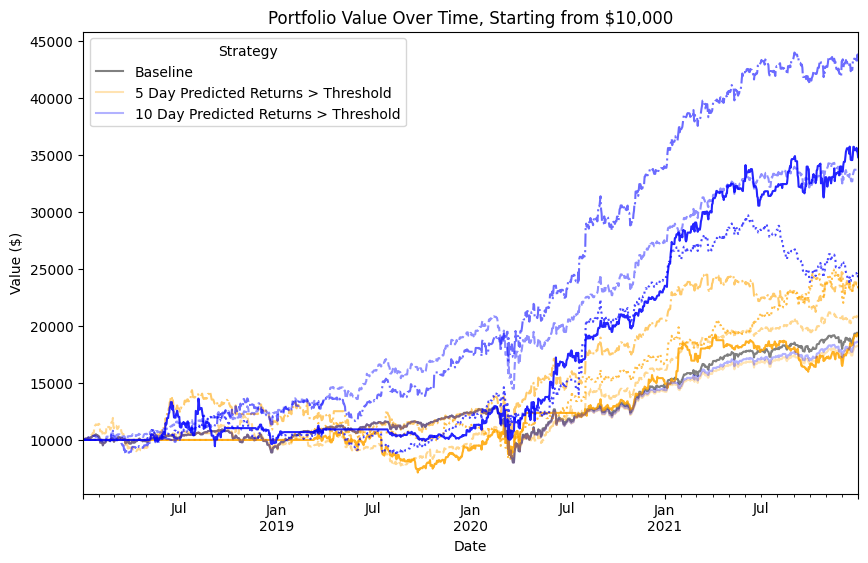

In [10]:
# In sample tests
t = df[(df.dt > datetime(2018, 1, 1)) & (df.dt < datetime(2022, 1, 1))].copy()
rows = []

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Color mapping for forecasts
forecast_colors = {
    'baseline': 'grey',
    'pred_5': 'orange',
    'pred_10': 'blue',
}

names = {
    'pred_5': '5 Day Predicted Returns',
    'pred_10': '10 Day Predicted Returns',
}


# Line styles for thresholds
linestyles = ['-', '--', '-.', ':']

# Baseline
t['signal'] = 1.0
port, pos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
port.reset_index().plot(x='date', y='portfolio_value', ax=ax, color='grey', label='Baseline')
total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
cagr = total_returns ** (1/years) - 1
sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
rows.append(["baseline", "n/a",
    f"{100*cagr:.2f}%",
    sharpe,
    f"{100*drawdowns.min():.2f}%",
])

# Forecasts with thresholds
for forecast in ['pred_5', 'pred_10']:
    color = forecast_colors[forecast]
    for i, threshold in enumerate(np.arange(0, 0.05, 0.01)):
        t['signal'] = (t[forecast] > threshold).astype(float)
        port, pos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
        port.reset_index().plot(
            x='date', y='portfolio_value', ax=ax,
            color=color,
            alpha=0.3 + 0.7 * (threshold / 0.05),  # increasing opacity
            linestyle=linestyles[i % len(linestyles)],
            label=f'{names[forecast]} > Threshold'
        )
        total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
        years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
        cagr = total_returns ** (1/years) - 1
        sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
        drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
        rows.append([
            forecast, threshold, 
            f"{100*cagr:.2f}%",
            sharpe,
            f"{100*drawdowns.min():.2f}%",
        ])

# Finalize plot
handles, labels = ax.get_legend_handles_labels()
# Keep only one label per forecast + baseline
seen = set()
filtered = [(h, l) for h, l in zip(handles, labels) if (key := l.split()[0]) not in seen and not seen.add(key)]
ax.legend(*zip(*filtered), title="Strategy")

ax.set_title("Portfolio Value Over Time, Starting from $10,000")
ax.set_ylabel("Value ($)")
ax.set_xlabel("Date")

# Output results DataFrame
results = pd.DataFrame(rows, columns=["forecast", "threshold", "cagr", "sharpe", "drawdown"])
results

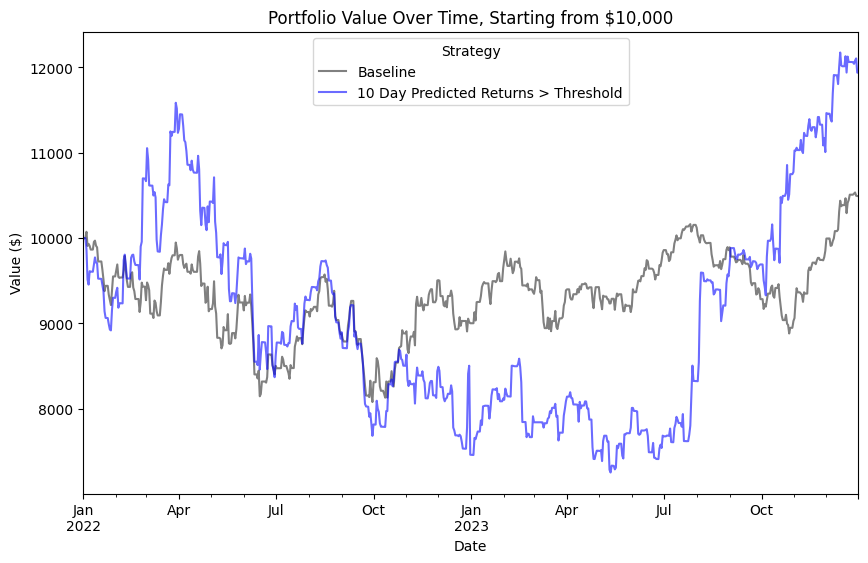

In [12]:
# Unseen data test
t = df[(df.dt >= datetime(2022, 1, 1)) & (df.dt < datetime(2024, 1, 1))].copy()

# 
rows = []

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Color mapping for forecasts
forecast_colors = {
    'baseline': 'grey',
    'pred_10': 'blue',
}

names = {
    'pred_10': '10 Day Predicted Returns',
}


# Line styles for thresholds
linestyles = ['-', '--', '-.', ':']

# Baseline
t['signal'] = 1.0
port, pos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
port.reset_index().plot(x='date', y='portfolio_value', ax=ax, color='grey', label='Baseline')
total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
cagr = total_returns ** (1/years) - 1
sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
rows.append(["baseline", "n/a",
    f"{100*cagr:.2f}%",
    sharpe,
    f"{100*drawdowns.min():.2f}%",
    f"{-cagr/drawdowns.min():.2f}",
])


# Forecasts with thresholds
for forecast in ['pred_10']:
    color = forecast_colors[forecast]
    for i, threshold in enumerate([0.02]):
        t['signal'] = (t[forecast] > threshold).astype(float)
        port, pos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
        port.reset_index().plot(
            x='date', y='portfolio_value', ax=ax,
            color=color,
            alpha=0.3 + 0.7 * (threshold / 0.05),  # increasing opacity
            linestyle=linestyles[i % len(linestyles)],
            label=f'{names[forecast]} > Threshold'
        )
        total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
        years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
        cagr = total_returns ** (1/years) - 1
        sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
        drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
        rows.append([
            forecast, threshold, 
            f"{100*cagr:.2f}%",
            sharpe,
            f"{100*drawdowns.min():.2f}%",
            f"{-cagr/drawdowns.min():.2f}",
        ])

# Finalize plot
handles, labels = ax.get_legend_handles_labels()
# Keep only one label per forecast + baseline
seen = set()
filtered = [(h, l) for h, l in zip(handles, labels) if (key := l.split()[0]) not in seen and not seen.add(key)]
ax.legend(*zip(*filtered), title="Strategy")

ax.set_title("Portfolio Value Over Time, Starting from $10,000")
ax.set_ylabel("Value ($)")
ax.set_xlabel("Date")

# Output results DataFrame
results = pd.DataFrame(rows, columns=["forecast", "threshold", "cagr", "sharpe", "drawdown", "cagr/drawdown"])

In [13]:
results

,forecast,threshold,cagr,sharpe,drawdown,cagr/drawdown
0,baseline,n/a,2.43%,0.183957,-19.80%,0.12
1,pred_10,0.02,9.27%,0.367605,-37.39%,0.25


## Feature Importance

In [14]:
# Train a model at the end of our dataset
m10_final = Ridge(alpha=1)
df = walk_forward_predict(df, m10_final, news_fts + submissions_fts + comments_fts, 'tgt_forward_returns_10', start_date=datetime(2023, 12, 31), end_date=datetime(2024, 1, 1), tgt_lookhead_offset=15)

2023-12-31 00:00:00
2024-01-01 00:00:00


In [22]:
# Analysing contributed error improvement from each group of sources
from sklearn.metrics import mean_squared_error

news_fts_reduced = [ft for ft in news_fts if ft.endswith("_10")]
submissions_fts_reduced = [ft for ft in submissions_fts if ft.endswith("_10")]
comments_fts_reduced = [ft for ft in comments_fts if ft.endswith("_10")]
features = news_fts_reduced + submissions_fts_reduced + comments_fts_reduced
reduced_sets = [
    ("without-reddit", news_fts_reduced),
    ("without-reddit-submissions", comments_fts_reduced+news_fts_reduced),
    ("without-reddit-comments", submissions_fts_reduced+news_fts_reduced),
    ("without-news", submissions_fts_reduced + comments_fts_reduced),
    ("all", news_fts_reduced + submissions_fts_reduced + comments_fts_reduced),
]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for name, fts in tqdm(reduced_sets):
    X_reduced = df[fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': name,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results)
errors

100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


,feature_set,contribution
0,without-reddit,0.349743
1,without-reddit-submissions,0.124626
2,without-reddit-comments,0.224664
3,without-news,0.646819
4,all,0.000000


In [39]:
# Importance of all features
from sklearn.metrics import mean_squared_error

features = news_fts + submissions_fts + comments_fts
features = [ft for ft in features if ft.endswith("_10")]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm(features):
    reduced_fts = [ft for ft in features if ft != removed]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

100%|██████████| 77/77 [01:15<00:00,  1.02it/s]


,feature_set,contribution
3,ft_news_the_associated_press_10,8.467682e-02
72,ft_comments_wallstreetbets_10,7.234898e-02
8,ft_news_slashgear_10,7.078467e-02
73,ft_comments_UpliftingNews_10,6.381246e-02
49,ft_news_android_police_10,5.214273e-02
...,...,...
17,ft_news_inverse_10,9.349111e-05
44,ft_news_toms_guide_10,9.298551e-05
52,ft_submissions_worldnews_10,3.100798e-05
75,ft_comments_Daytrading_10,2.745743e-06


In [40]:
# Most informative subreddits
from sklearn.metrics import mean_squared_error

features = news_fts + submissions_fts + comments_fts
features = [ft for ft in features if ft.endswith("_10")]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm([ft for ft in submissions_fts if ft.endswith('_10')]):
    reduced_fts = [ft for ft in features if ft != removed and ft != removed.replace('submission', 'comment')]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


,feature_set,contribution
9,ft_submissions_wallstreetbets_10,0.110673
10,ft_submissions_UpliftingNews_10,0.064327
11,ft_submissions_CryptoCurrency_10,0.040466
13,ft_submissions_Superstonk_10,0.022307
4,ft_submissions_finance_10,0.021231
5,ft_submissions_investing_10,0.015491
8,ft_submissions_StockMarket_10,0.015136
0,ft_submissions_politics_10,0.010834
3,ft_submissions_news_10,0.010664
2,ft_submissions_worldnews_10,0.008553


In [41]:
# Most informative news sources
from sklearn.metrics import mean_squared_error


news_fts_reduced = [ft for ft in news_fts if ft.endswith("_10")]
submissions_fts_reduced = [ft for ft in submissions_fts if ft.endswith("_10")]
comments_fts_reduced = [ft for ft in comments_fts if ft.endswith("_10")]
features = news_fts_reduced + submissions_fts_reduced + comments_fts_reduced
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm(news_fts_reduced):
    reduced_fts = [ft for ft in features if ft != removed]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


,feature_set,contribution
3,ft_news_the_associated_press_10,8.467682e-02
8,ft_news_slashgear_10,7.078467e-02
49,ft_news_android_police_10,5.214273e-02
34,ft_news_hot_hardware_10,4.224586e-02
5,ft_news_quartz_india_10,3.032042e-02
18,ft_news_wdiv_clickondetroit_10,2.407134e-02
12,ft_news_polygon_10,2.273508e-02
42,ft_news_new_york_post_10,2.085169e-02
37,ft_news_techspot_10,2.071287e-02
14,ft_news_the_boston_globe_10,1.950402e-02


In [42]:
# Most informative news sources
from sklearn.metrics import mean_squared_error


news_fts_reduced = [ft for ft in news_fts if ft.endswith("_10")]
submissions_fts_reduced = [ft for ft in submissions_fts if ft.endswith("_10")]
comments_fts_reduced = [ft for ft in comments_fts if ft.endswith("_10")]
features = news_fts_reduced + submissions_fts_reduced + comments_fts_reduced
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm(features):
    reduced_fts = [ft for ft in features if ft != removed]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

100%|██████████| 77/77 [01:05<00:00,  1.17it/s]


,feature_set,contribution
3,ft_news_the_associated_press_10,8.467682e-02
72,ft_comments_wallstreetbets_10,7.234898e-02
8,ft_news_slashgear_10,7.078467e-02
73,ft_comments_UpliftingNews_10,6.381246e-02
49,ft_news_android_police_10,5.214273e-02
...,...,...
17,ft_news_inverse_10,9.349111e-05
44,ft_news_toms_guide_10,9.298551e-05
52,ft_submissions_worldnews_10,3.100798e-05
75,ft_comments_Daytrading_10,2.745743e-06


In [47]:
full_model.coef_[:len(news_fts_reduced)].mean()

0.0004617674468027637

In [57]:
corrs = sorted([(ft, pearsonr(df[ft], df['tgt_forward_returns_10'])[0]) for ft in features], key=lambda x: x[1])
    

In [58]:
corrs

[('ft_comments_CryptoCurrency_10', -0.00371116019324886),
 ('ft_comments_Superstonk_10', -0.0032769371762117047),
 ('ft_comments_finance_10', -0.0028634946519936594),
 ('ft_news_newsweek_10', -0.002772886853520572),
 ('ft_news_ars_technica_10', -0.0027148787975946717),
 ('ft_news_techcrunch_10', -0.0025709032749934675),
 ('ft_news_wjw_fox_8_news_cleveland_10', -0.002448979588862636),
 ('ft_news_gamespot_10', -0.0022143507120597245),
 ('ft_news_gamesradar_10', -0.002039575130396742),
 ('ft_comments_worldnews_10', -0.0020025057036948037),
 ('ft_submissions_Daytrading_10', -0.0017589315278013363),
 ('ft_submissions_StockMarket_10', -0.001723196166079826),
 ('ft_news_wdwnt_10', -0.0017007505907359445),
 ('ft_news_wdiv_clickondetroit_10', -0.001652479015656347),
 ('ft_news_nbc10_boston_10', -0.0016499511991155758),
 ('ft_news_digital_trends_10', -0.0015754722015876048),
 ('ft_news_investing_10', -0.0015751021267550202),
 ('ft_news_android_authority_10', -0.0014644553549549425),
 ('ft_news_n

In [50]:
# Weights to show direction of correlation
weights = {k: full_model.coef_[i] for i, k in enumerate(features)}
print("Avg News Coef: ", np.mean([w for k, w in weights.items() if k.startswith("ft_news")]))
print("Avg Reddit Submission Coef: ", np.mean([w for k, w in weights.items() if k.startswith("ft_submissions")]))
print("Avg Reddit Comment Coef: ", np.mean([w for k, w in weights.items() if k.startswith("ft_comments")]))
print("Std Dev News Coef: ", np.std([w for k, w in weights.items() if k.startswith("ft_news")]))
print("Std Dev Reddit Submission Coef: ", np.std([w for k, w in weights.items() if k.startswith("ft_submissions")]))
print("Std Dev Reddit Comment Coef: ", np.std([w for k, w in weights.items() if k.startswith("ft_comments")]))
print("Median News Coef: ", np.median([w for k, w in weights.items() if k.startswith("ft_news")]))
print("Median Reddit Submission Coef: ", np.median([w for k, w in weights.items() if k.startswith("ft_submissions")]))
print("Median Reddit Comment Coef: ", np.median([w for k, w in weights.items() if k.startswith("ft_comments")]))

Avg News Coef:  0.0004617674468027637
Avg Reddit Submission Coef:  0.00045853147973579447
Avg Reddit Comment Coef:  2.0647802370786238e-05
Std Dev News Coef:  0.0034918729330782484
Std Dev Reddit Submission Coef:  0.0015993882872923934
Std Dev Reddit Comment Coef:  0.0022702225711593526
Median News Coef:  -0.0003833549219616289
Median Reddit Submission Coef:  0.0009119132422769946
Median Reddit Comment Coef:  -0.0002082143725559419


array([[<Axes: title={'center': 'x'}>]], dtype=object)

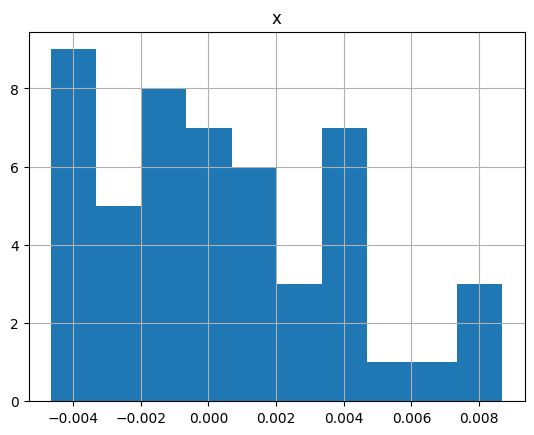

In [51]:
pd.DataFrame({"x": [w for k, w in weights.items() if k.startswith("ft_news")]}).hist()

array([[<Axes: title={'center': 'x'}>]], dtype=object)

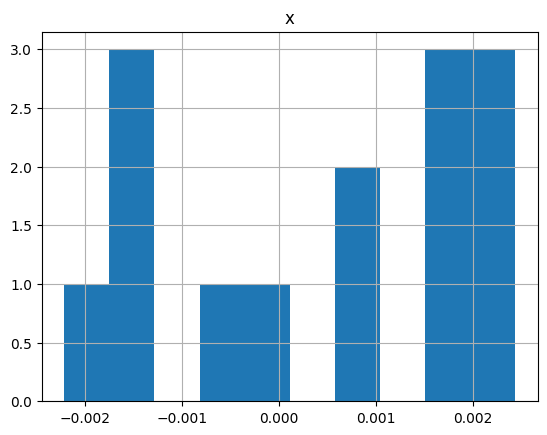

In [53]:
pd.DataFrame({"x": [w for k, w in weights.items() if k.startswith("ft_submissions")]}).hist()

array([[<Axes: title={'center': 'x'}>]], dtype=object)

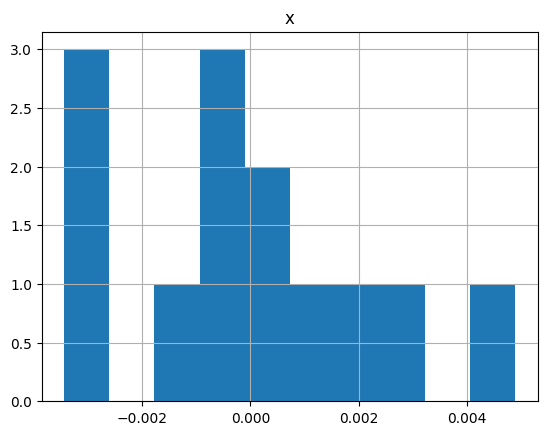

In [54]:
pd.DataFrame({"x": [w for k, w in weights.items() if k.startswith("ft_comments")]}).hist()

In [59]:
df.to_parquet("final.parquet")